In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [9]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=5
c = np.array([25, 25])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [25, 25+l_inner], [25, 25+l_inner+l]])


sub_regions = [[28,4,30,5],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.1/beta, 0.1/beta, 0.1/beta]

In [14]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


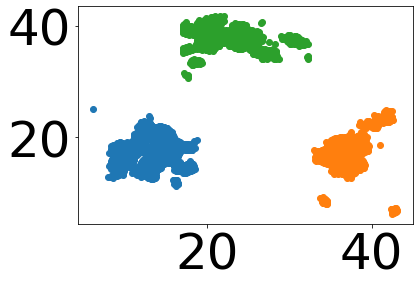

In [15]:
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])

In [16]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.6678115799803729, 0.7370320252593595, 0.7879781420765027]


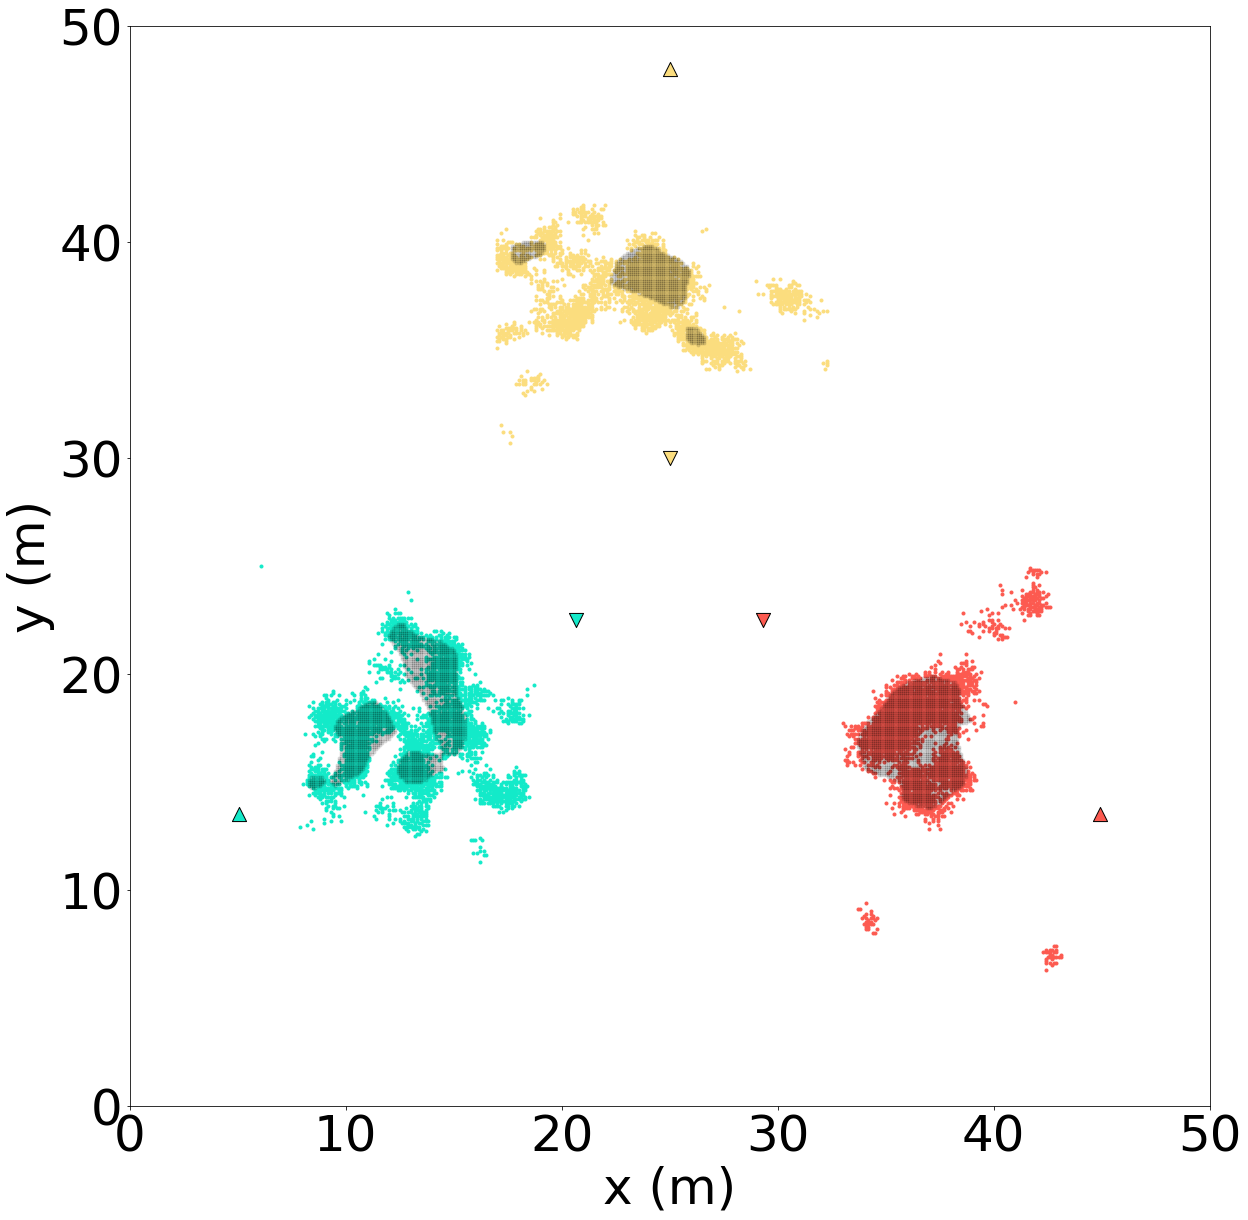

In [17]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [18]:
reload(MRP)
reload(PS)
reload(dtr)
reload(sim)


dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
15 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
6 total subregions


In [19]:
ps = dt_sys.ps

In [20]:
#Now look at effect of switching times on 
reload(sim)
v = 1
ps.Ls = np.array([0.1/beta, 0.01/beta, 0.01/beta])
print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])

#also look at the tabular version
rtable = SRP.SRPFromPis(pi, eps=0.01)
seconds = 2*60*60
xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)

Finding AORP
Found AORP


In [26]:
P_tilde, pi_tilde = sim.pi_to_P(pi)
sigma_tilde = pi_tilde.T @S @ pi_tilde
print(sigma_tilde)

11.81154790704074


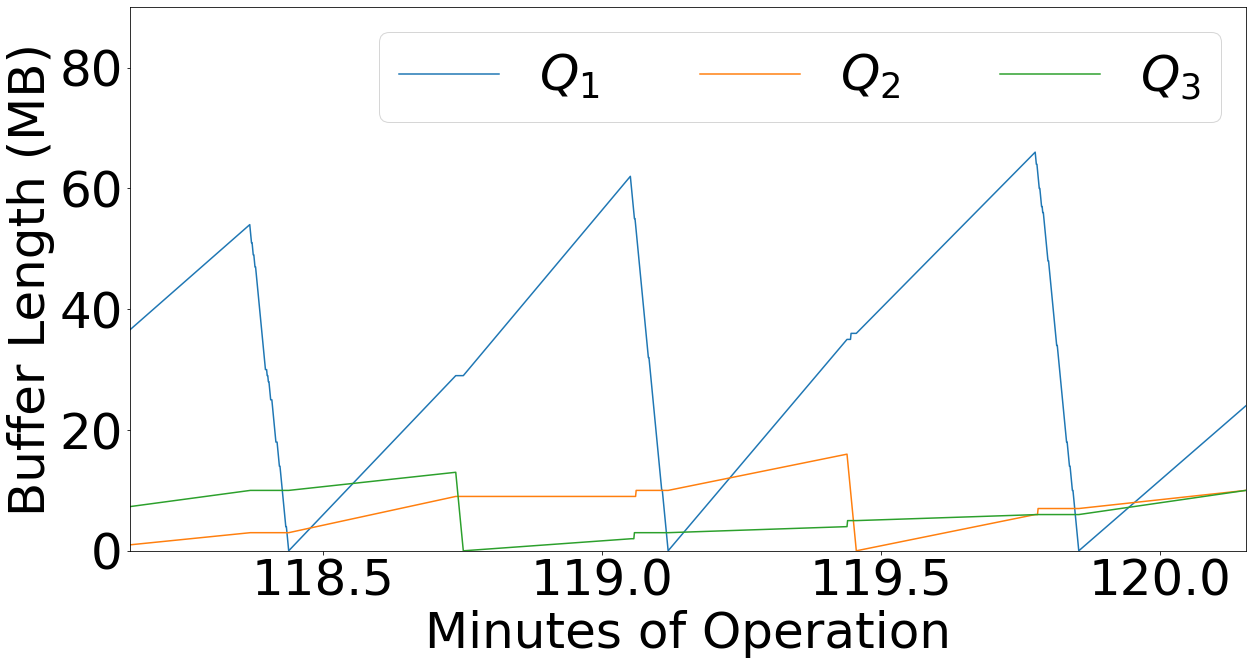

In [21]:
reload(sim)
sim.plotLastMins(xt, 2)
plt.ylim(0,90)
plt.show()

In [22]:
v2 = 2
xtv2, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S/v2, seconds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


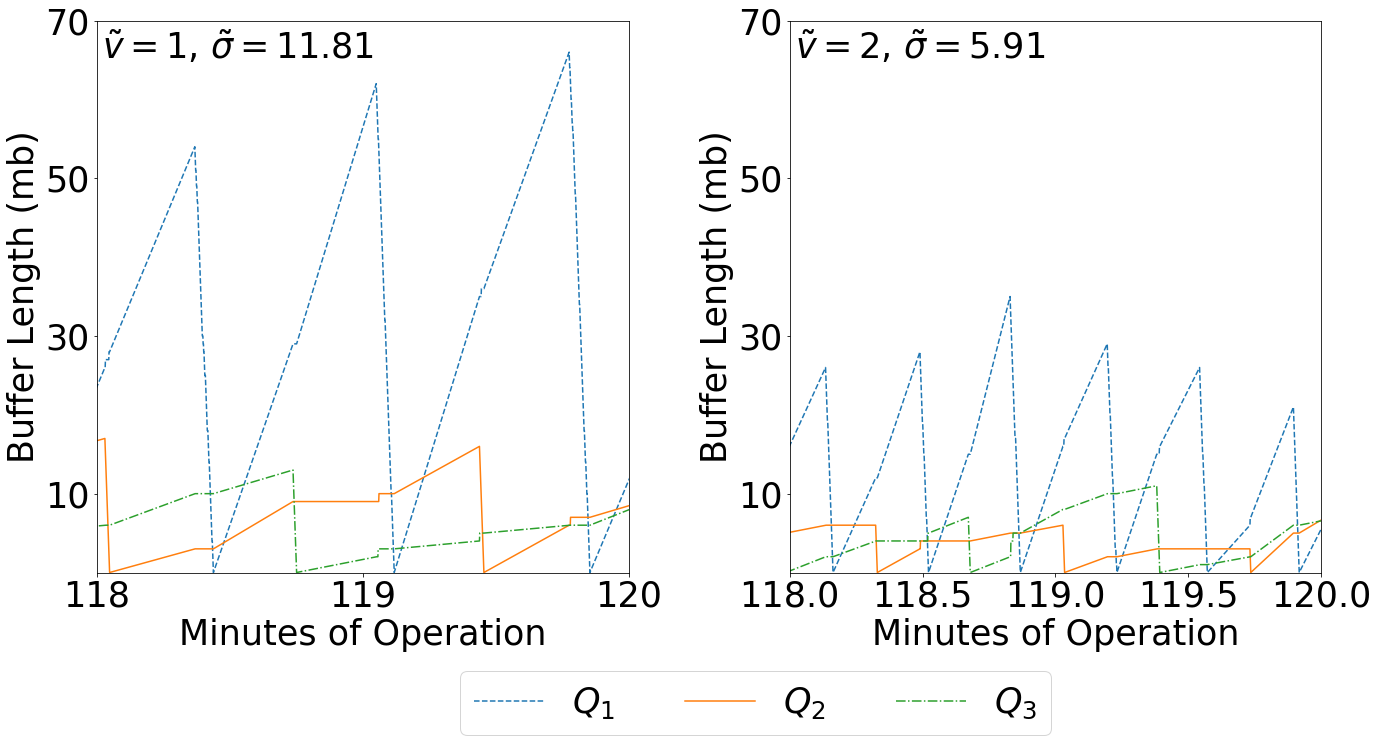

In [58]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
style=["--", "-", "-."]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
mins = 2
xt = np.array(xt)
nd = xt.shape[1]
for i in range(2,nd):
    ax1.plot(xt[:,0]/60, xt[:,i], linestyle=style[i-2], label = '$Q_%d$'%(i-1))

ax1.set_xlim((xt[-1,0]/60)-mins,xt[-1,0]/60)
ax1.set_ylim(0,70)
ax1.set_yticks([10, 30, 50, 70])
ax1.set_xlabel('Minutes of Operation')
ax1.set_xticks([118, 119, 120])
ax1.set_xlim(118, 120)
ax1.set_ylabel('Buffer Length (mb)')
ax1.annotate("$\\tilde{v} = 1$, $\\tilde{\\sigma} = %.2f$"%(sigma_tilde), xy=(0.01,0.93),xycoords='axes fraction',fontsize=35)

xtv2 = np.array(xtv2)
for i in range(2,nd):
    ax2.plot(xtv2[:,0]/60, xtv2[:,i], linestyle=style[i-2], label = '$Q_%d$'%(i-1))

ax2.set_xlim((xtv2[-1,0]/60)-mins,xtv2[-1,0]/60)
ax2.set_ylim(0,70)
# ax2.set_yticks([20, 40, 60, 80])
ax2.set_xlabel('Minutes of Operation')
ax2.set_yticks([10, 30, 50, 70])
ax2.set_xlim(118, 120)
ax2.set_ylabel('Buffer Length (mb)')
ax2.annotate("$\\tilde{v} = 2$, $\\tilde{\\sigma} = %.2f$"%(sigma_tilde/2), xy=(0.01,0.93),xycoords='axes fraction',fontsize=35)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=35, loc='upper center', bbox_to_anchor=[0.546,0.05], ncol=n)
fig.tight_layout()
fig.savefig("eq_tri_sample_buffer_length_2vs.png", format="png", bbox_inches="tight")
fig.savefig("eq_tri_sample_buffer_length_2vs.eps", format="eps", bbox_inches="tight")

In [36]:
#now look at effect of speed
ps.Ls = np.array([0.1/beta, 0.01/beta, 0.01/beta])
speeds = np.arange(0.5,10.5, 0.5)
ws = []
for speed in speeds:
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, speed)
    print("Found AORP")
    ws.append(AORP['WT'])


Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP


In [236]:
def wmg1(ps):
    term1 = 1/ps.RhoSys()
    term2 = ( ps.beta*ps.RhoSys()**2 )/ ( 2*(1 - ps.RhoSys()) )
    return term1 * term2

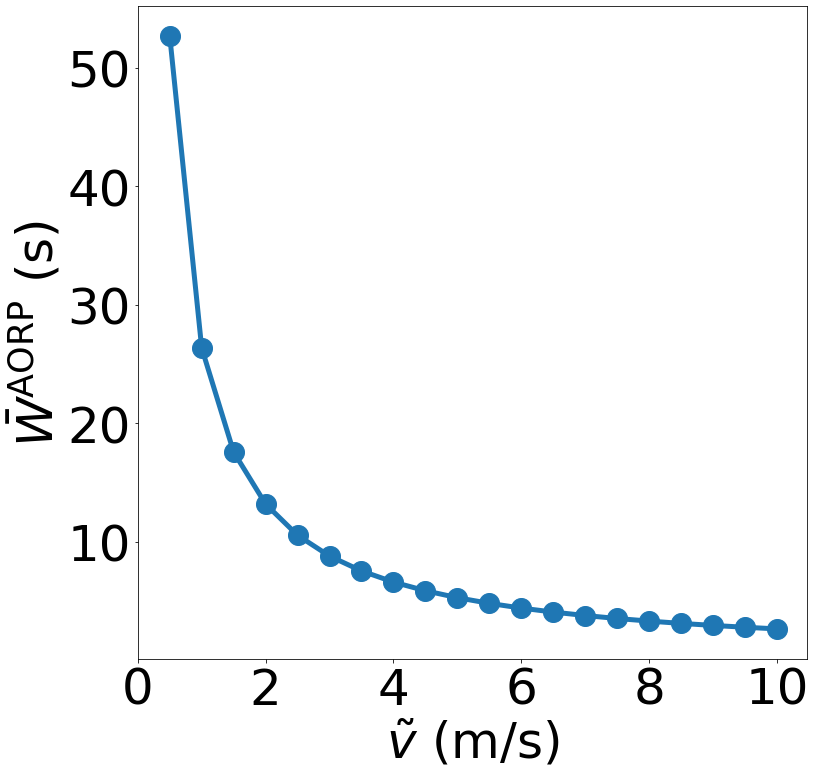

In [41]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 50})
fig = plt.figure(figsize=(12,12))
plt.plot(speeds, ws, '-o', linewidth=5, markersize=20)
plt.xlabel("$\\tilde{v}$ (m/s)")
plt.xticks([0,2,4,6,8,10])
plt.ylabel("$\\bar{W}^\mathrm{AORP}$ (s)")
fig.savefig("eq_tri_w_v_v.png", format="png", bbox_inches="tight")
fig.savefig("eq_tri_w_v_v.eps", format="eps", bbox_inches="tight")